In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sys
import sklearn
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [324]:
df = pd.read_csv("cleaner_data.csv")
print(df.size)
df.head()

88767


,Unnamed: 0,name,multiverse_id,color_identity,text,flavor,power
0,1,Ancestor's Chosen,NaN,['W'],First strike (This creature deals combat damag...,"""The will of all, by my hand done.""",4
1,2,Angel of Mercy,129465.0,['W'],Flying\r\nWhen Angel of Mercy enters the battl...,Every tear shed is a drop of immortality.,3
2,4,Angelic Blessing,129711.0,['W'],Target creature gets +3/+3 and gains flying un...,Only the warrior who can admit mortal weakness...,NaN
3,6,Angelic Chorus,129710.0,['W'],Whenever a creature enters the battlefield und...,The harmony of the glorious is a dirge to the ...,NaN
4,7,Angelic Wall,129671.0,['W'],Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't beg...",0


In [325]:
import re

def clean_color(text):
     # as cores são branco(W), preto(B), azul(U), vermelho(R) ou verde(G)
    pattern = r"\['(W|B|U|R|G)'\]"
    
    match = re.search(pattern, text)
    
    if match:
        return match.group(1)
    return None

df["color"] = df["color_identity"].apply(clean_color)
df.drop("color_identity", axis=1, inplace = True)

In [326]:
df["color"].value_counts()

color
W    2632
R    2575
B    2563
G    2475
U    2436
Name: count, dtype: int64

In [327]:
df["counterspell"] = (df.text.str.contains(r"[Cc]ounter\s(?:it|target|all)") & # anulações
         (df.text.str.contains(r"[wW]ard(?:\s{|—])") == False)) # Ward é uma maneira de anulação/proteção mais transversal às cores e é ignorada


df["exile"] = (df.text.str.contains(r"[eE]xile\s(?:target|each|all|the|up\sto)") & # exilar algo do tablueiro
        (df.text.str.contains(r"the\stop") == False)) # Algumas cartas "compram" cartas exilando-as do topo do deck, isso nào conta como exilar algo do tabuleiro

df["fight"] = (df.text.str.contains(r"[Ff]ights")) # Criaturas lutarem é uma mecânica característica do verde


df["mill"] = (df.text.str.contains(r"[mM]ill")) # TODO: mill é uma palavra chave recente, antes era referida por descartar a carta do >TOPO DO BATALHO<, bom adicionar este texto também


df["scry"] = (df.text.str.contains(r"[sS]cry"))


df["tap"] = (df.text.str.contains(r"(?:\st|T)ap\s(?:it|target|each|all|or\suntap)")) # cartas que viram outras 


df["untap"] = (df.text.str.contains(r"[uU]ntap\s(?:it|target|each|all)")) # find untappers

"""
df.loc[df.text.str.contains("[dD]eathtouch") | # find creatures that have deathtouch
        df.text.str.contains("deals combat damage to a creature, destroy that creature", regex = False)] # or that have "derptouch"
"""

df["double_strike"] = (df.text.str.contains(r"[dD]ouble\sstrike"))


df["first_strike"] = (df.text.str.contains(r"[fF]irst\sstrike"))


df["flash"] = (df.text.str.contains(r"(?:f|\nF|^F)lash") & # some engineering to avoid incorrectly grabbing cards with Flash in the name
        (df.text.str.contains(r"[fF]lashback") == False)) # dont' want to capture flashback


df["flying"] = (df.text.str.contains(r"[fF]lying"))


df["haste"] = (df.text.str.contains(r"[hH]aste"))


df["hexproof"] = (df.text.str.contains(r"[hH]exproof"))


df["indestructible"] = (df.text.str.contains(r"[iI]ndestructible") &
                         (df.text.str.contains(r"loses\sindestructible") == False))


df["sacrifice"] = (df.text.str.contains(r"[sS]acrifice"))


df["lifelink"] = (df.text.str.contains(r"[lL]ifelink"))


df["menace"] = (df.text.str.contains(r"[mM]enace"))


df["protection"] = (df.text.str.contains(r"[pP]rotection\sfrom"))


df["prowess"] = (df.text.str.contains(r"[pP]rowess"))


df["reach"] = (df.text.str.contains(r"(?:\sr|\nR|^R)each") &
        (df.text.str.contains(r"can't be blocked except by creatures with flying or reach", regex = False) == False)) # don't want flying reminder text


df["trample"] = (df.text.str.contains(r"[tT]rample"))


df["vigilance"] = (df.text.str.contains(r"[vV]igilance"))


df["draw"] = (df.text.str.contains(r"(?:\sd|\nD|^D)raw"))


df["discard"] = (df.text.str.contains(r"[dD]iscard"))


df["damage"] = (df.text.str.contains(r"deals\s\d\sdamage"))


df["damage_prevention"] = (df.text.str.contains(r"[pP]revent\s"))


df["life_gain"] = (df.text.str.contains(r"gain(?:\s|s\s)\d+\slife"))


df["life_loss"] = (df.text.str.contains(r"loses") & 
                   df.text.str.contains(r"(?:their|\d+)\slife")) # capture both fixed and rational values


df["tokens"] = (df.text.str.contains(r"[cC]reate"))


df["destroy"] = (df.text.str.contains(r"[dD]estroy") &
                  (df.text.str.contains(r"don't\sdestroy\sit.") == False)) # reject indestructible's reminder text


df["return"] = (df.text.str.contains(r"[rR]eturn") &
        df.text.str.contains(r"owner's\s(?:hand|library)") & # capture hand or library bounce effects
        (df.text.str.contains(r"graveyard\sto") == False)) # exclude grave recursion


df["recursion"] = (df.text.str.contains(r"\sput|return") &
        df.text.str.contains(r"graveyard")&
        df.text.str.contains(r"hand|battlefield"))

In [328]:
df.head()

,Unnamed: 0,name,multiverse_id,text,flavor,power,color,counterspell,exile,fight,...,draw,discard,damage,damage_prevention,life_gain,life_loss,tokens,destroy,return,recursion
0,1,Ancestor's Chosen,NaN,First strike (This creature deals combat damag...,"""The will of all, by my hand done.""",4,W,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,2,Angel of Mercy,129465.0,Flying\r\nWhen Angel of Mercy enters the battl...,Every tear shed is a drop of immortality.,3,W,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,4,Angelic Blessing,129711.0,Target creature gets +3/+3 and gains flying un...,Only the warrior who can admit mortal weakness...,NaN,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,6,Angelic Chorus,129710.0,Whenever a creature enters the battlefield und...,The harmony of the glorious is a dirge to the ...,NaN,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7,Angelic Wall,129671.0,Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't beg...",0,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [329]:
# Exibir todas as colunas e amostras de valores únicos em texto
print("\nNomes das colunas e valores únicos:")
for coluna in df.columns:
    print(f"\nColuna: {coluna}")
    print(df[coluna].unique())


Nomes das colunas e valores únicos:

Coluna: Unnamed: 0
[    1     2     4 ... 76228 76231 76232]

Coluna: name
["Ancestor's Chosen" 'Angel of Mercy' 'Angelic Blessing' ...
 'Vastwood Fortification // Vastwood Thicket' 'Veteran Adventurer'
 'Vine Gecko']

Coluna: multiverse_id
[    nan 129465. 129711. ... 491866. 491869. 491870.]

Coluna: text
["First strike (This creature deals combat damage before creatures without first strike.)\r\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."
 'Flying\r\nWhen Angel of Mercy enters the battlefield, you gain 3 life.'
 "Target creature gets +3/+3 and gains flying until end of turn. (It can't be blocked except by creatures with flying or reach.)"
 ... 'When Turntimber Ascetic enters the battlefield, you gain 3 life.'
 'Veteran Adventurer is also a Cleric, Rogue, Warrior, and Wizard.\r\nThis spell costs {1} less to cast for each creature in your party.\r\nVigilance'
 'The first kicked spell you cast ea

In [330]:
# Certifique-se de que os dados estão em formato de string antes de processar
df["flavor"] = df["flavor"].astype(str)  # Converte para string, caso não esteja

# Definir stop words
stop_words = set(stopwords.words("english"))  # Necessário baixar as stop words antes

stop_words.add('one')

# Define a função de preprocessamento
def preprocess(text, stop_words):
    # Remove pontuação e converte para minúsculas
    text = re.sub(r'[^\w\s]', '', text.lower())  
    # Tokeniza o texto
    tokens = word_tokenize(text)
    # Remove as stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]  
    return filtered_tokens

# Aplica a função a cada linha da coluna 'flavor'
df["processed_flavor"] = df["flavor"].apply(lambda x: preprocess(x, stop_words))

# Mostra o resultado
print(df)

       Unnamed: 0                                        name  multiverse_id  \
0               1                           Ancestor's Chosen            NaN   
1               2                              Angel of Mercy       129465.0   
2               4                            Angelic Blessing       129711.0   
3               6                              Angelic Chorus       129710.0   
4               7                                Angelic Wall       129671.0   
...           ...                                         ...            ...   
12676       76224                       Territorial Scythecat       491862.0   
12677       76225                          Turntimber Ascetic       491863.0   
12678       76228  Vastwood Fortification // Vastwood Thicket       491866.0   
12679       76231                          Veteran Adventurer       491869.0   
12680       76232                                  Vine Gecko       491870.0   

                                       

In [331]:
df['processed_flavor'] = df['processed_flavor'].apply(lambda x: ' '.join(x))

In [332]:
# Junta as palavras por cor única
df_grouped = df.groupby('color')['processed_flavor'].apply(lambda x: ' '.join(x)).reset_index()

# Inicializa o TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Ajusta e transforma os textos agregados por cor
tfidf_matrix = vectorizer.fit_transform(df_grouped['processed_flavor'])

# Converte a matriz TF-IDF para um DataFrame para visualização
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df_grouped['color']  # Define as cores únicas como índice
)

# Exibe o DataFrame TF-IDF
print(tfidf_df)

             07        10       100      1000    100000      1008        11  \
color                                                                         
B      0.000000  0.000000  0.000000  0.003325  0.000000  0.000000  0.000000   
G      0.000000  0.000000  0.003314  0.000000  0.000000  0.000000  0.000000   
R      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.004354   
U      0.004634  0.004634  0.003738  0.003738  0.004634  0.000000  0.000000   
W      0.000000  0.000000  0.000000  0.000000  0.000000  0.004082  0.000000   

          115th        12     136iv  ...     zurdi  zwinkerte       zyd  \
color                                ...                                  
B      0.004121  0.000000  0.000000  ...  0.000000   0.000000  0.000000   
G      0.000000  0.000000  0.000000  ...  0.006628   0.000000  0.009942   
R      0.000000  0.004354  0.000000  ...  0.000000   0.000000  0.003513   
U      0.000000  0.000000  0.000000  ...  0.003738   0.000000  0.000000

In [333]:
# Empilhar os dados para todas as cores e palavras
tfidf_data = tfidf_df.stack().reset_index()
tfidf_data.columns = ['color', 'word', 'tfidf']

# Ordenar os dados por TF-IDF de forma decrescente
top_tfidf_all = tfidf_data.sort_values(by='tfidf', ascending=False).head(20)

# Exibir o top 20
print(top_tfidf_all)

      color     word     tfidf
3761      B    death  0.331888
24651     G   forest  0.254447
9286      B     life  0.212094
46448     R     like  0.211628
65012     U     like  0.205338
83562     W    light  0.204260
3740      B     dead  0.200311
43817     R  goblins  0.195030
72164     U     time  0.187674
1696      B    blood  0.182636
69683     U      sea  0.181051
65846     U     mind  0.176635
29207     G   nature  0.166369
27850     G     life  0.164412
27884     G     like  0.160497
92054     W      war  0.159517
83542     W     life  0.157572
64576     U     know  0.154555
9320      B     like  0.153179
23427     G    elves  0.150419


In [334]:
# Empilhar os dados para todas as cores e palavras
tfidf_data = tfidf_df.stack().reset_index()
tfidf_data.columns = ['color', 'word', 'tfidf']

# Ordenar os dados por TF-IDF de forma decrescente para pegar as 20 palavras mais relevantes
top_tfidf_all = tfidf_data.sort_values(by='tfidf', ascending=False).head(20)

# Pegar as 20 palavras mais relevantes
top_20_words = top_tfidf_all['word'].unique()

# Filtrar a matriz TF-IDF para as 20 palavras mais relevantes
filtered_tfidf = tfidf_df[top_20_words]

# Exibir o TF-IDF das 20 palavras para as 5 cores específicas
top_20_tfidf = filtered_tfidf.loc[df['color'].unique()[:5]]  # Aqui você pode ajustar o número de cores ou selecionar específicas
print(top_20_tfidf)

          death    forest      life      like     light      dead   goblins  \
color                                                                         
W      0.099212  0.005836  0.157572  0.124501  0.204260  0.058360  0.013617   
U      0.055198  0.006624  0.075070  0.205338  0.030911  0.033119  0.017663   
B      0.331888  0.007855  0.212094  0.153179  0.043204  0.200311  0.005891   
R      0.072618  0.004150  0.068468  0.211628  0.035271  0.049795  0.195030   
G      0.084163  0.254447  0.164412  0.160497  0.033274  0.035231  0.003915   

           time     blood       sea      mind    nature       war      know  \
color                                                                         
W      0.103103  0.050579  0.015563  0.031125  0.009727  0.159517  0.079759   
U      0.187674  0.022079  0.181051  0.176635  0.035327  0.048575  0.154555   
B      0.098192  0.182636  0.027494  0.082481  0.021602  0.054987  0.084445   
R      0.099590  0.128637  0.024897  0.037346  0.02

In [335]:
# Calcular a soma dos valores de TF-IDF para cada palavra
tfidf_sum = tfidf_df.sum(axis=0)

# Identificar palavras a remover: TF-IDF > 0.1 em todas as cores e soma > 0.6
words_to_remove = []

for word in tfidf_df.columns:
    if all(tfidf_df[word] > 0.1) and tfidf_sum[word] > 0.6:
        words_to_remove.append(word)

words_to_remove.append('color')
# Remover as palavras identificadas
filtered_tfidf_df = tfidf_df.drop(columns=words_to_remove)

# Exibir as palavras removidas
print("Palavras removidas:", words_to_remove)

Palavras removidas: ['like', 'color']


In [336]:
# Calcular a soma dos valores de TF-IDF para cada palavra
tfidf_sum = tfidf_df.sum(axis=0)

# Identificar palavras a remover: TF-IDF > 0.1 em todas as cores e soma > 0.6
words_to_remove = []

for word in tfidf_df.columns:
    if all(tfidf_df[word] > 0.06) and tfidf_sum[word] > 0.2:
        words_to_remove.append(word)
def remove_words(text, words_to_remove):
    # Divide o texto em palavras
    words = text.split()
    # Filtra as palavras, removendo as que estão na lista 'words_to_remove'
    filtered_words = [word for word in words if word.lower() not in words_to_remove]
    # Junta as palavras restantes de volta em uma string
    return ' '.join(filtered_words)
            
words_to_remove.append('color')
# Remover as palavras identificadas
filtered_tfidf_df = tfidf_df.drop(columns=words_to_remove)

# Aplicar a função à coluna 'processed_flavor'
df['processed_flavor'] = df['processed_flavor'].apply(lambda x: remove_words(x, words_to_remove))

# Exibir as palavras removidas
print("Palavras removidas:", words_to_remove)

Palavras removidas: ['dont', 'know', 'life', 'like', 'long', 'make', 'power', 'time', 'world', 'color']


In [337]:
print(df['processed_flavor'])

0                                                hand done
1                         every tear shed drop immortality
2        warrior admit mortal weakness bolstered immort...
3                            harmony glorious dirge wicked
4        ancestor protects us ways cant begin comprehen...
                               ...                        
12676              standing scythecat prey makes appetizer
12677    land cried pain flow returns balance point new...
12678    understand natures ways youre never unarmed ey...
12679                                           assistance
12680    cute things tend get lot bigger youre looking ...
Name: processed_flavor, Length: 12681, dtype: object


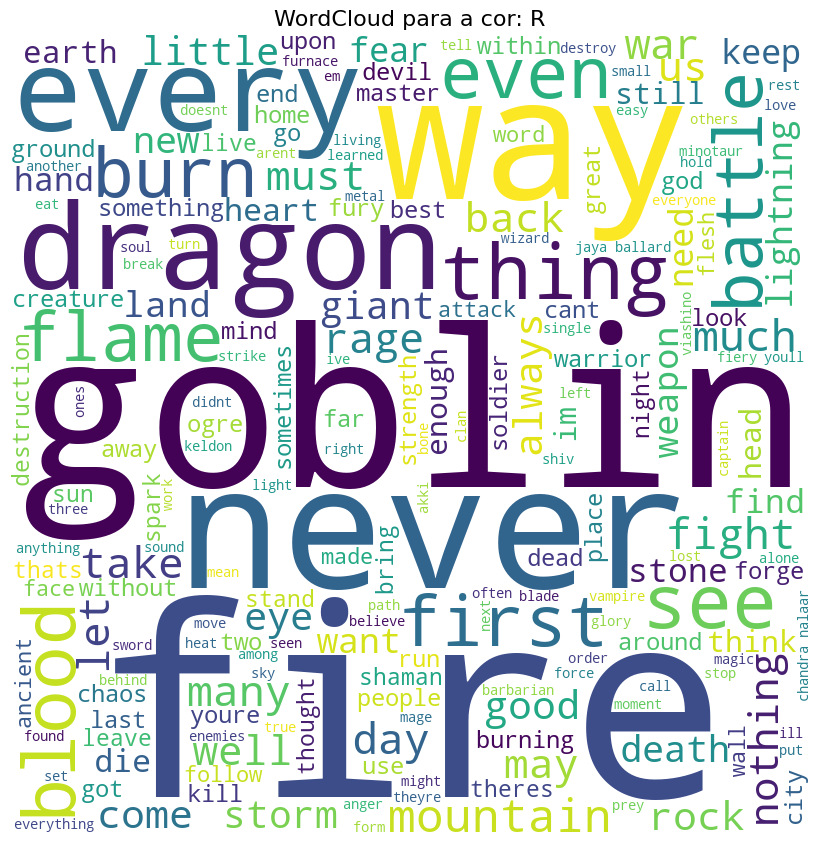

In [338]:
# Função para gerar o WordCloud para uma cor específica
def gerar_wordcloud_cor(cor, df):
    # Filtra as linhas onde a coluna 'color' contém a cor desejada
    filtered_words = df[df['color'].str.contains(cor, case=False, na=False)]['processed_flavor']

    # Cria uma string com todas as palavras filtradas
    comment_words = ' '.join(filtered_words)

    # Verifica se há palavras filtradas antes de gerar o WordCloud
    if comment_words:
        # Gerar o WordCloud com o texto filtrado
        wordcloud = WordCloud(width=800, height=800,
                              background_color='white',
                              stopwords=STOPWORDS,
                              min_font_size=10).generate(comment_words)

        # Exibe a imagem do WordCloud para a cor
        plt.figure(figsize=(8, 8), facecolor=None)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.tight_layout(pad=0)

        # Adiciona título com o nome da cor
        plt.title(f"WordCloud para a cor: {cor}", fontsize=16)
        plt.show()
    else:
        print(f"Não há palavras associadas à cor: {cor}")

# Escolha a cor desejada para o WordCloud
cor_escolhida = 'R'  # Exemplo: 'red', pode substituir por qualquer cor

# Chama a função para gerar o WordCloud para a cor escolhida
gerar_wordcloud_cor(cor_escolhida, df)


In [339]:
print(df['processed_flavor'])

0                                                hand done
1                         every tear shed drop immortality
2        warrior admit mortal weakness bolstered immort...
3                            harmony glorious dirge wicked
4        ancestor protects us ways cant begin comprehen...
                               ...                        
12676              standing scythecat prey makes appetizer
12677    land cried pain flow returns balance point new...
12678    understand natures ways youre never unarmed ey...
12679                                           assistance
12680    cute things tend get lot bigger youre looking ...
Name: processed_flavor, Length: 12681, dtype: object


In [340]:
from nltk.tokenize import word_tokenize

all_words = []

for message in df['processed_flavor']:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

# Print the result
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

Number of words: 18735
Most common words: [('never', 390), ('even', 344), ('death', 323), ('every', 320), ('see', 288), ('us', 280), ('would', 265), ('must', 247), ('many', 237), ('first', 225), ('may', 218), ('always', 216), ('could', 216), ('way', 215), ('war', 213)]


In [341]:
print(df['color'].value_counts())


color
W    2632
R    2575
B    2563
G    2475
U    2436
Name: count, dtype: int64


In [342]:
print(tfidf_df)

             07        10       100      1000    100000      1008        11  \
color                                                                         
B      0.000000  0.000000  0.000000  0.003325  0.000000  0.000000  0.000000   
G      0.000000  0.000000  0.003314  0.000000  0.000000  0.000000  0.000000   
R      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.004354   
U      0.004634  0.004634  0.003738  0.003738  0.004634  0.000000  0.000000   
W      0.000000  0.000000  0.000000  0.000000  0.000000  0.004082  0.000000   

          115th        12     136iv  ...     zurdi  zwinkerte       zyd  \
color                                ...                                  
B      0.004121  0.000000  0.000000  ...  0.000000   0.000000  0.000000   
G      0.000000  0.000000  0.000000  ...  0.006628   0.000000  0.009942   
R      0.000000  0.004354  0.000000  ...  0.000000   0.000000  0.003513   
U      0.000000  0.000000  0.000000  ...  0.003738   0.000000  0.000000

In [343]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Tokenize as frases
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_flavor'])

# Obter os termos (vocabulário) usados no TF-IDF
terms = vectorizer.get_feature_names_out()

# Suponha que df_tfidf seja o DataFrame com cores como índices e termos como colunas
# Exemplo fictício de df_tfidf:
# df_tfidf = pd.DataFrame(np.random.rand(5, len(terms)), index=['red', 'blue', 'green', 'black', 'white'], columns=terms)

# Agora, crie uma função para calcular a pontuação de cada cor com base nos termos
def calculate_color_score(row, tfidf_df, terms):
    # Inicializa a pontuação de cada cor
    color_scores = {color: 0 for color in tfidf_df.index}
    
    # Para cada termo na frase (linha)
    for term, value in zip(terms, row):
        if value > 0:  # Se o termo aparece na frase
            for color in tfidf_df.index:
                if term in tfidf_df.columns:  # Verifica se o termo existe em df_tfidf
                    # Adiciona o valor do TF-IDF do termo para a cor correspondente
                    color_scores[color] += tfidf_df.loc[color, term] * value
    
    return color_scores

# Converter a matriz esparsa para uma forma densa (convertendo para um array NumPy)
X_dense = X.toarray()

# Aplicar a função a cada linha (cada frase)
df['test_color'] = [calculate_color_score(row, tfidf_df, terms) for row in X_dense]

# Se quiser, pode criar uma nova coluna para a cor com maior pontuação
df['predicted_color'] = df['test_color'].apply(lambda x: max(x, key=x.get))



In [344]:
print(df['predicted_color'][0])
print(df['test_color'][0])

B
{'B': 0.032999766368912026, 'G': 0.013155882130795703, 'R': 0.02789139280351448, 'U': 0.025229083446313815, 'W': 0.026151077300714264}


In [357]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Supondo que 'df' tenha as colunas 'color' (rótulos verdadeiros) e 'test_color' (scores das cores)

# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(df['test_color'], df['color'], test_size=0.2, random_state=42)

# Treinar o modelo nos dados de treino
# Aqui você pode substituir por seu modelo e treinamento específico
# Exemplo de um modelo simples (você pode substituir por seu código real)
# Vamos assumir que a coluna 'test_color' contém pontuações associadas às cores
# E vamos prever a cor com maior pontuação
y_pred_train = X_train.apply(lambda x: max(x, key=x.get))  # Previsão no conjunto de treino
y_pred_test = X_test.apply(lambda x: max(x, key=x.get))  # Previsão no conjunto de teste

# Calcular a acurácia no conjunto de treino
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'Acc no conjunto de treino: {accuracy_train:.4f}')

# Calcular a acurácia no conjunto de teste
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Acc no conjunto de teste: {accuracy_test:.4f}')


Acc no conjunto de treino: 0.7055
Acc no conjunto de teste: 0.7040


In [360]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

# Exemplo de como os dados podem estar estruturados
# df = pd.DataFrame({
#     'color': ['red', 'blue', 'green'],
#     'test_color': [{'red': 0.1, 'blue': 0.9}, {'red': 0.2, 'blue': 0.8}, {'red': 0.3, 'blue': 0.7}]
# })

# Preparar as variáveis X e y
X = np.array([list(color.values()) for color in df['test_color']])  # Converter os dicionários em listas de pontuações
y = df['color']

# Codificar as classes (cores) como números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Converter as labels para one-hot encoding
y_one_hot = to_categorical(y_encoded)

# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

In [367]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.utils import to_categorical
from keras.optimizers import SGD 
# Criar o modelo
model = Sequential()

# Camada de entrada com 128 neurônios e função de ativação 'relu'
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

# Camada oculta adicional 1
model.add(Dense(64, activation='relu'))

# Camada oculta adicional 2
model.add(Dense(32, activation='relu'))

# Camada de Dropout para prevenir overfitting
model.add(Dropout(0.2))

# Camada de saída com a função de ativação 'softmax' (para classificação multiclasse)
model.add(Dense(y_one_hot.shape[1], activation='softmax'))

# Compilar o modelo com o otimizador 'adam' e a função de perda 'categorical_crossentropy'
sgd_optimizer = SGD(learning_rate=0.01)  # Definindo a taxa de aprendizado do SGD
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                     │ (None, 128)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,269 (44.02 KB)

 Trainable params: 11,269 (44.02 KB)

 Non-trainable params: 0 (0.00 B)

In [368]:
# Treinar o modelo
history = model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2403 - loss: 1.6075 - val_accuracy: 0.3926 - val_loss: 1.6040
Epoch 2/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3053 - loss: 1.6027 - val_accuracy: 0.3930 - val_loss: 1.6021
Epoch 3/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3088 - loss: 1.6015 - val_accuracy: 0.3110 - val_loss: 1.6015
Epoch 4/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3191 - loss: 1.6006 - val_accuracy: 0.3816 - val_loss: 1.6007
Epoch 5/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3031 - loss: 1.5994 - val_accuracy: 0.2783 - val_loss: 1.6000
Epoch 6/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2731 - loss: 1.5991 - val_accuracy: 0.3650 - val_loss: 1.5994
Epoch 7/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3085 - loss: 1.5991 - val_accuracy: 0.2538 - val_loss: 1.5989
Epoch 8/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2865 - loss: 1.5974 - 

In [369]:
# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Acc no conjunto de teste: {accuracy:.4f}')


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6978 - loss: 0.8555 
Acc no conjunto de teste: 0.7012


In [370]:
# Fazer previsões com novos dados (aqui usamos X_test como exemplo)
y_pred = model.predict(X_test)

# Converter a previsão (vetor de probabilidades) para a classe com maior probabilidade
y_pred_classes = np.argmax(y_pred, axis=1)

# Decodificar a classe de volta para a cor
predicted_colors = label_encoder.inverse_transform(y_pred_classes)

# Mostrar as previsões
print(f'Previsões: {predicted_colors}')


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Previsões: ['G' 'B' 'R' ... 'U' 'R' 'W']
